## Imports

In [1]:
!hostnamectl

 Static hostname: DGX
       Icon name: computer-server
         Chassis: server 🖳
      Machine ID: dedf5691225742ff95b33f842b0781cc
         Boot ID: cb04df0ff1774eeda112c63867eeefdd
Operating System: ]8;;https://www.ubuntu.com/Ubuntu 24.04.2 LTS]8;;              
          Kernel: Linux 6.8.0-53-generic
    Architecture: x86-64
 Hardware Vendor: NVIDIA
  Hardware Model: DGXA100 920-23687-2530-002
Firmware Version: 1.29
   Firmware Date: Tue 2024-08-06
    Firmware Age: 7month


In [ ]:
%pip install -r requirements.txt

import sys
import os
sys.path.append('../src')
from data_preprocessing import data_preprocessing_tumor
from model import BrainCNN, EarlyStopping
from collections import defaultdict



import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


In [3]:
train_loader, valid_loader, test_loader = data_preprocessing_tumor()
print("data was successfully loaded")

data was successfully loaded


In [4]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")


Train dataset size: 4916
Validation dataset size: 1404
Test dataset size: 703


In [ ]:

def count_images_per_class(loader):
    class_counts = defaultdict(int)

    for _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1  

    return class_counts

train_class_counts = count_images_per_class(train_loader)
valid_class_counts = count_images_per_class(valid_loader)
test_class_counts = count_images_per_class(test_loader)

print("Train loader class counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nValidation loader class counts:")
for class_label, count in valid_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nTest loader class counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")


Train loader class counts:
Class 3: 1245 images
Class 1: 1152 images
Class 2: 1391 images
Class 0: 1128 images

Validation loader class counts:
Class 3: 328 images
Class 2: 408 images
Class 1: 327 images
Class 0: 341 images

Test loader class counts:
Class 1: 166 images
Class 3: 184 images
Class 2: 201 images
Class 0: 152 images


In [6]:
# Hyperparameters

num_epochs=50
patience=3
delta = 0.001
learning_rate=0.001
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BrainCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3)

early_stopping = EarlyStopping(patience=patience, delta=delta)

# Metrics for runtime calculations

train_loss_metr = []
val_loss_metr = []

train_acc_metr = []
val_acc_metr = []


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        _, predicted = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        
    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_targets = []
    val_preds = []
    
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
            
            val_targets.extend(target.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
    
    val_loss /= len(valid_loader.dataset)
    val_acc = correct_val / total_val
    
    train_loss_metr.append(train_loss)
    val_loss_metr.append(val_loss)
    train_acc_metr.append(train_acc)
    val_acc_metr.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Epoch {epoch+1}: Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}")
    print('\n')

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break



torch.save(model.state_dict(), "./braincnn_prototype.weights")

Epoch 1: Train Loss: 1.1354, Val Loss: 1.4586
Epoch 1: Train acc: 0.4546, Val acc: 0.2885


Epoch 2: Train Loss: 0.8487, Val Loss: 1.1778
Epoch 2: Train acc: 0.6638, Val acc: 0.5734


Epoch 3: Train Loss: 0.6994, Val Loss: 0.9251
Epoch 3: Train acc: 0.7335, Val acc: 0.6709


Epoch 4: Train Loss: 0.6333, Val Loss: 0.9904
Epoch 4: Train acc: 0.7561, Val acc: 0.6838


Epoch 5: Train Loss: 0.5823, Val Loss: 0.7279
Epoch 5: Train acc: 0.7752, Val acc: 0.7372


Epoch 6: Train Loss: 0.5531, Val Loss: 0.5890
Epoch 6: Train acc: 0.7866, Val acc: 0.7813


Epoch 7: Train Loss: 0.5122, Val Loss: 0.5948
Epoch 7: Train acc: 0.7982, Val acc: 0.7913


Epoch 8: Train Loss: 0.4814, Val Loss: 0.5525
Epoch 8: Train acc: 0.8157, Val acc: 0.8063


Epoch 9: Train Loss: 0.4550, Val Loss: 0.4601
Epoch 9: Train acc: 0.8273, Val acc: 0.8283


Epoch 10: Train Loss: 0.4487, Val Loss: 0.4416
Epoch 10: Train acc: 0.8251, Val acc: 0.8462


Epoch 11: Train Loss: 0.4164, Val Loss: 0.3623
Epoch 11: Train acc: 0.8458, Va

In [7]:
early_stopping.load_best_model(model)

# Final evaluation on the test set
model.eval()
correct = 0
total = 0
test_targets = []
test_preds = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        test_targets.extend(target.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

test_accuracy =  correct / total

precision = precision_score(test_targets, test_preds, average='weighted')
recall = recall_score(test_targets, test_preds, average='weighted')
f1 = f1_score(test_targets, test_preds, average='weighted')

# Print the results
print('Metrics of the model on the test images:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

with open("training_metrics.pkl", "wb") as f:
    pickle.dump({
        "train_loss": train_loss_metr,
        "val_loss": val_loss_metr,
        "train_acc": train_acc_metr,
        "val_acc": val_acc_metr,
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }, f)

torch.save(model.state_dict(), "./braincnn_prototype.weights")

Metrics of the model on the test images:
Accuracy: 0.9545
Precision: 0.9545
Recall: 0.9545
F1 Score: 0.9543


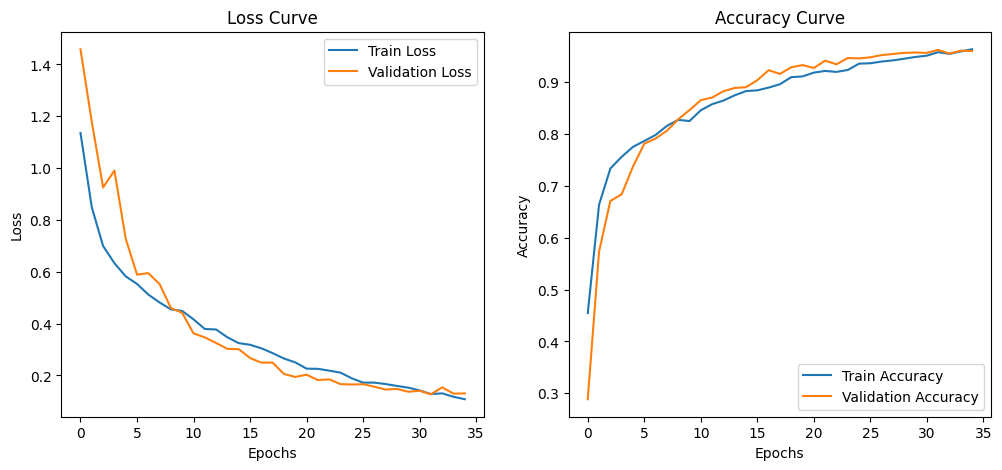

In [8]:
# Load metrics
with open("training_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

train_loss_metr = metrics["train_loss"]
val_loss_metr = metrics["val_loss"]
train_acc_metr = metrics["train_acc"]
val_acc_metr = metrics["val_acc"]

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_metr, label='Train Loss')
plt.plot(val_loss_metr, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_metr, label='Train Accuracy')
plt.plot(val_acc_metr, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.savefig("training_plots.png", dpi=300, bbox_inches="tight")  # Сохранение в файл
plt.show()


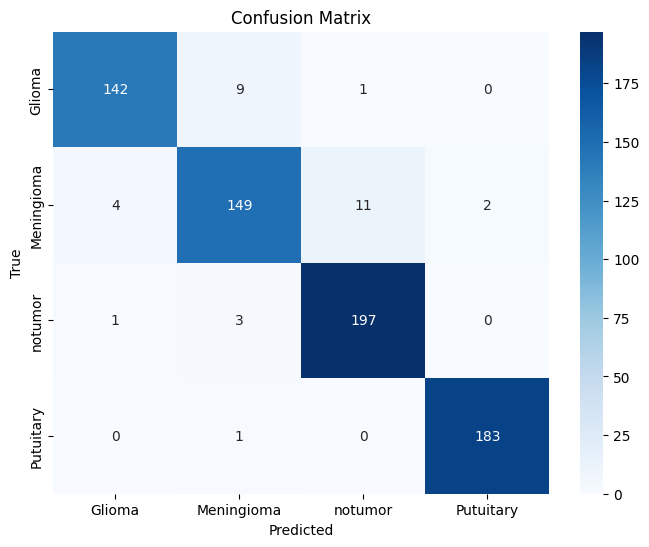

In [9]:


cm = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Glioma', 'Meningioma', 'notumor', 'Putuitary'], 
            yticklabels=['Glioma', 'Meningioma', 'notumor', 'Putuitary'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

